## 005 Research Model with Data Augmentation

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np
from keras.models import load_model

from pylab import rcParams
rcParams['figure.figsize'] = (10,8)

In [3]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../51c5ca37'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [4]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

In [19]:
# INSPECT : look at class 1 = benign and 2 = papilloma, 3 = dysplasia+carcinoma

#render.plot_image(x_train[0])
#print(y_train[122])

#render.plot_image(x_train[2])
#print(y_train[2])

#render.plot_image(x_train[8])
#print(y_train[8])


In [5]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [6]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [23]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_from_previous_research_dropout(input_shape=(64,64,3), num_classes=3)
display(model.summary())

# parameters:
learning_rate = 1e-4

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
activation_33 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 15, 15, 192)       196800    
_________________________________________________________________
activation_34 (Activation)   (None, 15, 15, 192)       0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 192)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7, 192)         0         
__________

None

In [24]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[3 3 1 3 1 1 3 3 3 1 3 1 3 3 3 3 2 3 3 2 3 1 3 3 3 2 1 3 3 2 3 3 3 1 3 3 1
 1 3 3 1 3 3 3 3 1 1 1 3 2 3 2 3 3 1 2 3 3 3 2 3 1 3 1 3 3 3 3 1 1 1 3 3 3
 1 3 1 1 3 3 1 2 3 2 3 1 3 3 2 3 3 3 2 3 3 2 3 3 1 3] [2 3 2 1 1 3 2 1 1 3 3 1 3 3 3 1 3 3 3 3 1 3 1 1 1 3 2 2 3 3 3 2 2 3 3 1 1
 1 1 3 3 3 2 1 3 2 3 3 3 3 3 3 3 1 3 1 3 3 3 3 3 3 3 3 3 2 3 2 3 1 2 2 1 3
 1 3 3 3 3 2 3 3 1 3 3 1 3 2 3 3 3 1 3 2 1 1 3 1 2 2] [2 2 3 1 1 1 2 2 2 2 2 2 2 3 1 1 3 1 2 1 3 3 2 3 2 3 3 2 2 3 3 1 3 3 3 3 3
 3 2 2 1 1 2 1 3 1 1 3 1 2 1 3 3 1 3 3 2 1 3 3 2 3 3 2 3 3 2 1 2 1 3 2 2 3
 1 1 1 2 2 1 2 3 3 1 3 1 2 3 3 2 1 3 2 1 1 1 2 1 3 2]


In [25]:
## Now Let's do a run with data augmentation
reload(cnn_models)
from keras.preprocessing.image import ImageDataGenerator

# parameters
epochs = 12
batch_size = 16

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=30,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


#datagen.fit(x_train)


#history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size),
#                              epochs = epochs, validation_data = (x_test,y_test_oh),
#                              workers = 4,
#                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
#                              , callbacks=[cnn_models.annealer()])


history = model.fit(x_train,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[cnn_models.annealer(2)])

Train on 4159 samples, validate on 352 samples
Epoch 1/12
4159/4159 [==============================] - 25s 6ms/step - loss: 0.6899 - acc: 0.7723 - val_loss: 0.6443 - val_acc: 0.8182
Epoch 2/12
4159/4159 [==============================] - 23s 6ms/step - loss: 0.6046 - acc: 0.7978 - val_loss: 0.6011 - val_acc: 0.8267
Epoch 3/12
4159/4159 [==============================] - 23s 6ms/step - loss: 0.5719 - acc: 0.8086 - val_loss: 0.5391 - val_acc: 0.8267
Epoch 4/12
4159/4159 [==============================] - 23s 6ms/step - loss: 0.6001 - acc: 0.8072 - val_loss: 0.5445 - val_acc: 0.8267
Epoch 5/12
4159/4159 [==============================] - 23s 6ms/step - loss: 0.5617 - acc: 0.8161 - val_loss: 0.5589 - val_acc: 0.8267

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/12
4159/4159 [==============================] - 23s 6ms/step - loss: 0.5294 - acc: 0.8298 - val_loss: 0.5294 - val_acc: 0.8267
Epoch 7/12
4159/4159 [==============================] - 23s 6m

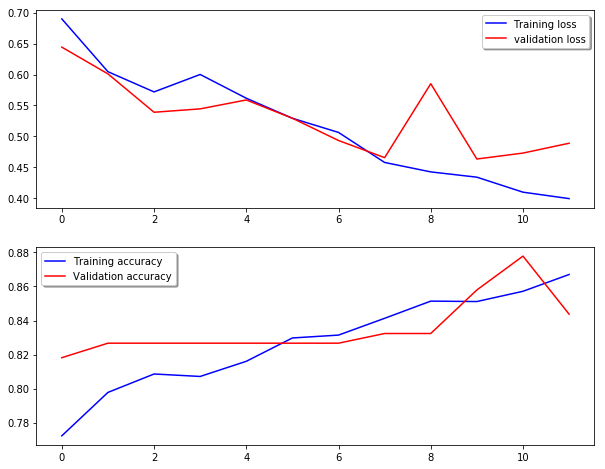

Precision (specificity): 81.878%
Recall (sensitivity): 57.519%
Accuracy: 60.748%
F1: 55.967%


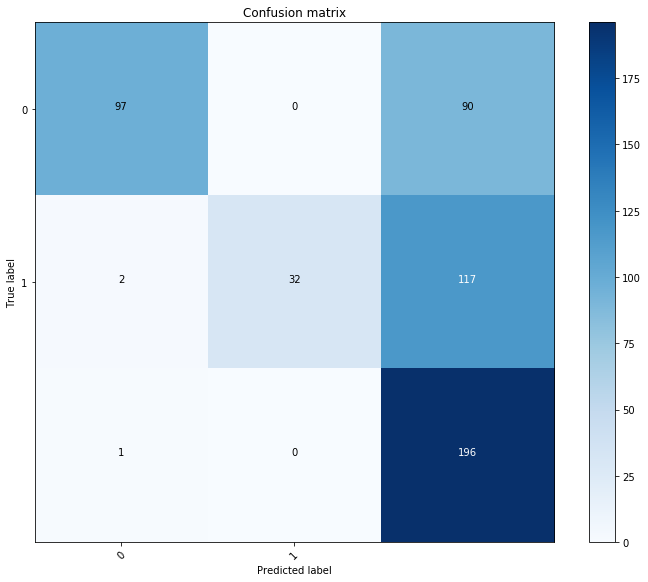

In [26]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [27]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

odi-819f9608 [0.03319702 0.15817824 0.8086248 ] 1
hgv-2cdb69f6 [0.04796537 0.29066047 0.66137415] 1
odi-a981441f [0.12637223 0.04255741 0.83107036] 1
mdi-5e3d3832 [0.61536235 0.04800747 0.33663017] 0
mdi-461bdebc [0.04247374 0.13249797 0.82502836] 2
mdi-5e3d3832 [0.01391743 0.02605071 0.9600319 ] 2
mdi-9abd4637 [0.02124909 0.08211672 0.89663416] 2
mdi-e3b0c312 [0.0174527 0.0634684 0.919079 ] 0
mdi-f3f9ede5 [0.49900904 0.02246306 0.4785278 ] 0


In [28]:
model.save('model_005_dataaug2_adamopt_sp.h5')

In [ ]:
## FIXES:
load_model()